# Analysis 과정 - Deep Learning

## Tensorflow 개요

### `tensorflow` 란?

_**Tensor**_ + _**Flow**_

* _**Tensor**_ (점)  
: 데이터를 저장, 운반하기 위한 `class`.


* _**Flow**_ (선)  
: 데이터를 처리하는 동작.

점과 선이 모여 그래프를 만들듯이, `tensorflow`에서도 _**Tensor**_와 _**Flow**_가 모여 `tf.Graph`를 만들게 된다.  
그래서 `tensorflow`를 Graph 기반의 딥러닝 Framework라고 한다.
<br>

<img src='images/mlp_tf/tensorflow_graph_and_session.png' width='80%' align='center'>

<br>


In [52]:
import tensorflow as tf
import numpy as np
import unipy as up
from pprint import pprint
import random
import matplotlib.pyplot as plt

### Tensor : `tf.Tensor`

<br>

`tf.Tensor`는 `tensorflow` 내에서 데이터를 저장, 운반하기 위해 정의된 `class`이다.  
자주 쓰이는 method로는 `eval`, `get_shape` 등이 있다.

Tensor라는 이름은 __다차원 행렬을 뜻하는 수학용어__에서 차용했으며, 말 그대로 고차원 행렬이다.  
`np.ndarray`와 유사한 개념으로 이해할 수 있다.

* `tf.Tensor`를 생성하기 위한 `tf.Operation`
  - `tf.constant()` : __고정값__ 행렬 생성
  - `tf.Variable()` : 점점 __업데이트 되는(학습 되는)__ 행렬 생성
  - `tf.placeholder()` : 데이터 변수를 받아들이기 위한 __비어 있는__ 행렬 생성
  
<br>

일단, 하나씩 실습해 보자.

In [54]:
constant_t = tf.constant([[1, 2, 3],
                        [4, 5, 6]])
constant_t

<tf.Tensor 'Const_1:0' shape=(2, 3) dtype=int32>

In [55]:
constant_t.get_shape()

TensorShape([Dimension(2), Dimension(3)])

In [56]:
variable_t = tf.Variable([1,2])
variable_t

<tf.Variable 'Variable:0' shape=(2,) dtype=int32_ref>

In [57]:
variable_t.shape

TensorShape([Dimension(2)])

In [58]:
placeholder_t = tf.placeholder(dtype=tf.float32, shape=(1,))
placeholder_t

<tf.Tensor 'Placeholder:0' shape=(1,) dtype=float32>

In [59]:
a = placeholder_t.get_shape()

In [60]:
a.as_list()

[1]

### Flow : `tf.Operation`

<br>

`tf.Tensor`를 만들었지만, 이상하게도 아직 거기에 데이터가 담겨 있지는 않다.  
일단 __*Tensor*__ 부분을 작업했으니, 우선 __*Flow*__도 한번 만들어 보자.  


간단하게 행렬곱을 계산하는 Flow를 구현해 보자.

<img src="images/mlp_tf/graph_concept_new.png" width=500 height=500 align="center">



* 행렬값 만들기

In [61]:
np.random.seed(0)
arr_a = np.random.randint(10, size=(2, 3))
arr_b = np.random.randint(10, size=(3, 1))


pprint(arr_a)
pprint(arr_b)

array([[5, 0, 3],
       [3, 7, 9]])
array([[3],
       [5],
       [2]])


* 행렬값으로 `tf.Tensor` 만들기

In [62]:
tensor_a = tf.constant(arr_a, dtype=tf.int32)
tensor_b = tf.constant(arr_b, dtype=tf.int32)

print(
    f'tensor_a shape : {tensor_a.get_shape()}',
    f'tensor_b shape : {tensor_b.get_shape()}',
    sep='\n',
)

tensor_a shape : (2, 3)
tensor_b shape : (3, 1)


* 행렬곱 계산하기 (`op: operation`)

In [63]:
matmul_op = tf.matmul(tensor_a, tensor_b)

matmul_op

<tf.Tensor 'MatMul:0' shape=(2, 1) dtype=int32>

### `tf.Session` &  `tf.Graph`

__*Tensor*__와 __*Flow*__를 만들었지만, 아직 결과값을 얻지는 못했다.  
이는 `tensorflow`가 기본적으로 __*lazy evaluation*__ 방식으로 실행되기 때문이다.

`tensorflow`는 다음과 같은 순서로 코드를 빌드하고, 실행한다.


<div class="alert alert-block alert-warning">
<b>$\divideontimes$ Tensorflow 동작 순서  </b>

<br>

1. Tensor와 Flow로 `tf.Graph`를 만든다.
2. `tf.Session`으로 Graph 실행을 위한 세션을 시작하고, 그래프를 세션에 올린다.
3. (`tf.Variable`이 있을 경우, 초기값으로 설정해 준다.)
4. `tf.Session.run`으로 Flow를 실행해서, 결과값을 받는다.

</div>  


우선 `tf.constant`만 사용했으니, 3번을 생략하고 계산해 보자.

In [64]:
#=== Session Start =========================#
sess = tf.Session()

result = sess.run(matmul_op)

sess.close()
#=== Session Close =========================#

result

array([[21],
       [62]], dtype=int32)

<div class="alert alert-block alert-success">
<b>$\divideontimes$ Session 실행 시 주의점 </b>

<br>

`sess = tf.Session()`로 세션을 열었다면, Operation 수행 후에는 꼭 `sess.close()`로 열린 세션을 닫아 주어야 한다.  
그렇지 않을 경우, 컴퓨터는 아직 작업이 끝나지 않았다고 생각해 세션이 활성화된 상태로 GPU 메모리 상에 그래프를 계속 올려놓게 된다.

이런 번거로움을 방지하기 위해, python에서는 `with` 구문을 활용하여 다음과 같이 구현한다.

```py
with tf.Session() as sess:
    result = sess.run(matmul_op)

print(result)

```


</div>

이번에는 `tf.Variable`을 사용할 경우를 알아보자.

`tf.Variable`은, 학습을 위해 업데이트할 수 있는 기능을 가진 특수한 Tensor이다.  
여기에 값을 부여하는 경우, 처음 시작할 때 초기값으로만 활용되고  
Optimizer로 Backpropagation을 수행하면서 <font color='#318CE7'> <b><i>값이 점차 바뀌게 된다.</i></b></font>

그래서 *__초기값을 부여하기 위한 추가 Operation이 필요하다.__*

* 초기값 만들기

In [65]:
np.random.seed(0)
arr_a = np.random.randint(10, size=(2, 3))
arr_v = np.random.randint(10, size=(3, 1))

pprint(arr_a)
pprint(arr_v)

array([[5, 0, 3],
       [3, 7, 9]])
array([[3],
       [5],
       [2]])


* 초기값으로 `tf.Variable` 만들기

In [66]:
tensor_a = tf.constant(arr_a, dtype=tf.int32)

tensor_v = tf.Variable(arr_v, dtype=tf.int32)  # 연산을 위해 type 맞추기
tensor_v

<tf.Variable 'Variable_1:0' shape=(3, 1) dtype=int32_ref>

* `matmul_v_op`로 행렬곱 계산하기

In [67]:
matmul_v_op = tf.matmul(tensor_a, tensor_v, name='variable_matmul_op')

matmul_v_op

<tf.Tensor 'variable_matmul_op:0' shape=(2, 1) dtype=int32>

* `tf.Session`으로 실행하기

In [68]:
init_op = tf.global_variables_initializer()

#=== Session Start =========================#
with tf.Session() as sess:
    
    sess.run(init_op)
    result = sess.run(matmul_op)

#=== Session Close =========================#

result

array([[21],
       [62]], dtype=int32)

### __Scope__

기본적으로 Graph의 모든 Operation들은 `name`을 지정해서 관리한다.  
이 `name`은 Tensor 값을 확인하거나 debugging할 때, tf.Variable을 선택해서 업데이트할 때 등 많은 경우에 필수적이다.

하지만 그래프가 복잡해질 경우, 일일이 name을 지정해서 관리하기 쉽지 않다.  
그래프 관리를 위해 계층 구조로 묶게 되는데, 이 묶음의 단위가 __scope__이다.  

프로그래밍 언어의 namespace 개념과 비슷하다. 모든 node는 __scope__에 종속된다.  
이 때 종속된다는 뜻은, <font color='#318CE7' size='4'><b><i>한 scope에는 한 name만 가능하다는 뜻이다.</i></b></font>


<img src='images/mlp_tf/tensorflow_scope.png'>



#### `tf.name_scope`

`Variable`을 제외한 모든 Operation을 종속시킨다.  
__만약 이름이 중복되면, suffix로 번호를 매겨 추가해 버린다.__

`name_scope`의 이름이 중복될 경우에도 추가한다.  
즉, <font color='#318CE7' size='4'><b><i>`name_scope`는 처음 정의하는 것으로 역할을 다한다.</i></b></font>

In [69]:
with tf.name_scope('test_name_scope') as scope:
    
    tensor_a0 = tf.constant(9, dtype=tf.int32, name='constant_a')
    tensor_a1 = tf.constant([1, 2], dtype=tf.int32, name='constant_a')
    tensor_b0 = tf.Variable(7, dtype=tf.int32, name='variable_a')
    tensor_b1 = tf.Variable([2, 3], dtype=tf.int32, name='variable_a')


print(
    f'{tensor_a0.name}  ->  {tensor_a0.shape}',
    f'{tensor_a1.name}  ->  {tensor_a1.shape}',
    f'{tensor_b0.name}  ->  {tensor_b0.shape}',
    f'{tensor_b1.name}  ->  {tensor_b1.shape}',
    sep='\n',
)

test_name_scope/constant_a:0  ->  ()
test_name_scope/constant_a_1:0  ->  (2,)
test_name_scope/variable_a:0  ->  ()
test_name_scope/variable_a_1:0  ->  (2,)


* `tf.name_scope`는 다시 호출할 수 없으며, scope 및 변수 재사용은 불가능하다.

In [70]:
with tf.name_scope('test_name_scope') as scope:
    
    tensor_a2 = tf.constant([9, 1, 3], dtype=tf.int32, name='constant_a')
    tensor_b2 = tf.Variable([6, 7, 8], dtype=tf.int32, name='variable_a')


print(
    f'{tensor_a2.name}  ->  {tensor_a2.shape}',
    f'{tensor_b2.name}  ->  {tensor_b2.shape}',
    sep='\n',
)

test_name_scope_1/constant_a:0  ->  (3,)
test_name_scope_1/variable_a:0  ->  (3,)


#### `tf.variable_scope`

`Variable`과 Operation 모두를 종속시키며,  
__재사용이 가능하므로 정의한 후 다시 호출할 수 있다.__

__만약 이름이 중복되면, `ValueError`를 발생시킨다.__

`variable_scope`의 이름을 다시 사용하면 해당 scope를 재사용한다는 뜻이다.  
`name_scope`에서 suffix가 붙은 것과는 다르게 동작한다.  
즉, <font color='#318CE7' size='4'><b><i>`variable_scope`로 Layer를 자유롭게 재사용할 수 있다.</i></b></font>


In [71]:
with tf.variable_scope('test_variable_scope', reuse=tf.AUTO_REUSE) as scope:
    
    tensor_a0 = tf.constant(9, dtype=tf.int32, name='constant_a')
    tensor_b0 = tf.Variable(7, dtype=tf.int32, name='variable_a')


print(
    f'{tensor_a0.name}  ->  {tensor_a0.shape}',
    f'{tensor_b0.name}  ->  {tensor_b0.shape}',
    sep='\n',
)

test_variable_scope/constant_a:0  ->  ()
test_variable_scope/variable_a:0  ->  ()


In [72]:
with tf.variable_scope('test_variable_scope', reuse=True) as scope:
    
    tensor_a1 = tf.constant([1, 2], dtype=tf.int32, name='constant_a')
    tensor_b1 = tf.Variable([2, 3], dtype=tf.int32, name='variable_a')


print(
    f'{tensor_a1.name}  ->  {tensor_a1.shape}',
    f'{tensor_b1.name}  ->  {tensor_b1.shape}',
    sep='\n',
)

test_variable_scope_1/constant_a:0  ->  (2,)
test_variable_scope_1/variable_a:0  ->  (2,)


* `variable_scope` 내에서도 `tf.Variable`은 같은 이름이 번호가 매겨지며 계속 선언된다.  
그래서 다시 호출할 때, 원하는 이름의 Variable을 선택하기 힘들어진다.

Variable을 한 번에 하나의 이름만 사용하기 위해, <font color='#318CE7' size='4'><b><i>`tf.get_variable`을 사용한다.</i></b></font>

In [73]:
with tf.variable_scope('test_error_variable_scope', reuse=tf.AUTO_REUSE) as scope:
    
    tensor_a0 = tf.constant(9, dtype=tf.int32, name='constant_a')
    tensor_a1 = tf.constant([1, 2], dtype=tf.int32, name='constant_a')
    tensor_b0 = tf.Variable(7, dtype=tf.int32, name='variable_a')
    tensor_b1 = tf.Variable([2, 3], dtype=tf.int32, name='variable_a')


with tf.variable_scope('test_error_variable_scope', reuse=tf.AUTO_REUSE) as scope:
    
    tensor_a2 = tf.constant([9, 1, 3], dtype=tf.int32, name='constant_a')
    tensor_b2 = tf.Variable([6, 7, 8], dtype=tf.int32, name='variable_a')


print(
    f'{tensor_a0.name}  ->  {tensor_a0.shape}',
    f'{tensor_a1.name}  ->  {tensor_a1.shape}',
    f'{tensor_b0.name}  ->  {tensor_b0.shape}',
    f'{tensor_b1.name}  ->  {tensor_b1.shape}',
    f'{tensor_a2.name}  ->  {tensor_a2.shape}',
    f'{tensor_b2.name}  ->  {tensor_b2.shape}',
    sep='\n',
)

test_error_variable_scope/constant_a:0  ->  ()
test_error_variable_scope/constant_a_1:0  ->  (2,)
test_error_variable_scope/variable_a:0  ->  ()
test_error_variable_scope/variable_a_1:0  ->  (2,)
test_error_variable_scope_1/constant_a:0  ->  (3,)
test_error_variable_scope_1/variable_a:0  ->  (3,)


In [78]:
tf.reset_default_graph()

try:

    with tf.variable_scope('test_error_variable_scope', reuse=tf.AUTO_REUSE) as scope:

        tensor_a0 = tf.constant(9, dtype=tf.int32, name='constant_a')
        tensor_a1 = tf.constant([1, 2], dtype=tf.int32, name='constant_a')
        tensor_b0 = tf.get_variable(
            'variable_a',
             shape=(1, ),
             dtype=tf.int32,
             initializer=tf.constant_initializer(7),
        )
        tensor_b1 = tf.get_variable(
            'variable_a',
             shape=(2, ),
             dtype=tf.int32,
             initializer=tf.constant_initializer([2, 3]),
        )


    with tf.variable_scope('test_error_variable_scope', reuse=tf.AUTO_REUSE) as scope:

        tensor_a2 = tf.constant([9, 1, 3], dtype=tf.int32, name='constant_a')
        tensor_b2 = tf.Variable([6, 7, 8], dtype=tf.int32, name='variable_a')


    print(
        f'{tensor_a0.name}  ->  {tensor_a0.shape}',
        f'{tensor_a1.name}  ->  {tensor_a1.shape}',
        f'{tensor_b0.name}  ->  {tensor_b0.shape}',
        f'{tensor_b1.name}  ->  {tensor_b1.shape}',
        f'{tensor_a2.name}  ->  {tensor_a2.shape}',
        f'{tensor_b2.name}  ->  {tensor_b2.shape}',
        sep='\n',
    )

except ValueError as err:

    print('Variable Mismatch.')

Variable Mismatch.


In [79]:
tf.reset_default_graph()


with tf.variable_scope('test_error_variable_scope', reuse=tf.AUTO_REUSE) as scope:

    tensor_a0 = tf.constant(9, dtype=tf.int32, name='constant_a')
    tensor_a1 = tf.constant([1, 2], dtype=tf.int32, name='constant_a')
    tensor_b0 = tf.get_variable(
        'variable_a',
         shape=(1, ),
         dtype=tf.int32,
         initializer=tf.constant_initializer(7),
    )
    tensor_b1 = tf.get_variable(
        'variable_b',
         shape=(2, ),
         dtype=tf.int32,
         initializer=tf.constant_initializer([2, 3]),
    )


with tf.variable_scope('test_error_variable_scope', reuse=tf.AUTO_REUSE) as scope:

    tensor_a2 = tf.constant([9, 1, 3], dtype=tf.int32, name='constant_a')
    tensor_b2 = tf.Variable([6, 7, 8], dtype=tf.int32, name='variable_b')


print(
    f'{tensor_a0.name}  ->  {tensor_a0.shape}',
    f'{tensor_a1.name}  ->  {tensor_a1.shape}',
    f'{tensor_b0.name}  ->  {tensor_b0.shape}',
    f'{tensor_b1.name}  ->  {tensor_b1.shape}',
    f'{tensor_a2.name}  ->  {tensor_a2.shape}',
    f'{tensor_b2.name}  ->  {tensor_b2.shape}',
    sep='\n',
)


test_error_variable_scope/constant_a:0  ->  ()
test_error_variable_scope/constant_a_1:0  ->  (2,)
test_error_variable_scope/variable_a:0  ->  (1,)
test_error_variable_scope/variable_b:0  ->  (2,)
test_error_variable_scope_1/constant_a:0  ->  (3,)
test_error_variable_scope_1/variable_b:0  ->  (3,)


#### scope 사용 예시

* Dense Layer

In [23]:
def dense_layer(
    input_x,
    output_dim,
    activation=tf.nn.sigmoid,
    is_training=True,
    reuse=tf.AUTO_REUSE,
    name='dense',
    ):
    
    with tf.variable_scope(name, reuse=reuse):
        densed = tf.layers.dense(
            input_x,
            units=output_dim,
            activation=activation,
            kernel_initializer=tf.random_normal_initializer(),
            name=name,
        )

    print(name, densed.get_shape())

    return densed

##### 모델 구현

* $y = (w_{1}x_{1} + w_{2}x_{2} + b) + (w_{a} + w_{b})$

In [80]:
tf.reset_default_graph()

with tf.name_scope('input_layer'):
    
    #x_1 = tf.placeholder(tf.float32, shape=(1,), name='input_x_1')
    #x_2 = tf.placeholder(tf.float32, shape=(1,), name='input_x_2')
    
    x_1 = tf.constant(9., dtype=tf.float32, name='input_x_1')
    x_2 = tf.constant(4., dtype=tf.float32, name='input_x_2')

    
with tf.variable_scope('multiply_layer', reuse=tf.AUTO_REUSE):

    weight_1 = tf.get_variable('multiply_weight_1', shape=(1,), dtype=tf.float32, initializer=tf.random_normal_initializer())
    weight_2 = tf.get_variable('multiply_weight_2', shape=(1,), dtype=tf.float32, initializer=tf.random_normal_initializer())

    multiply_op_1 = weight_1 * x_1
    multiply_op_2 = weight_2 * x_2

with tf.variable_scope('add_layer', reuse=tf.AUTO_REUSE):
    
    add_op = multiply_op_1 + multiply_op_2


with tf.variable_scope('multiply_layer', reuse=True):
    
    reuse_weight_1 = tf.get_variable('multiply_weight_1', dtype=tf.float32)
    reuse_weight_2 = tf.get_variable('multiply_weight_2', dtype=tf.float32)

    subtract_weight_op = reuse_weight_1 - reuse_weight_2


with tf.name_scope('output_layer'):
    
    result_op = add_op + subtract_weight_op

    
print(
    '=' * 70,
    f'{x_1.name}  ->  {x_1.shape}',
    f'{x_2.name}  ->  {x_2.shape}',
    '=' * 70,
    f'{weight_1.name}  ->  {weight_1.shape}',
    f'{weight_2.name}  ->  {weight_2.shape}',
    f'{multiply_op_1.name}  ->  {multiply_op_1.shape}',
    f'{multiply_op_2.name}  ->  {multiply_op_2.shape}',
    '=' * 70,
    f'{add_op.name}  ->  {add_op.shape}',
    '=' * 70,
    f'{reuse_weight_1.name}  ->  {reuse_weight_1.shape}',
    f'{reuse_weight_2.name}  ->  {reuse_weight_2.shape}',
    f'{subtract_weight_op.name}  ->  {subtract_weight_op.shape}',
    '=' * 70,
    f'{result_op.name}  ->  {result_op.shape}',
    '=' * 70,
    sep='\n',
)

input_layer/input_x_1:0  ->  ()
input_layer/input_x_2:0  ->  ()
multiply_layer/multiply_weight_1:0  ->  (1,)
multiply_layer/multiply_weight_2:0  ->  (1,)
multiply_layer/mul:0  ->  (1,)
multiply_layer/mul_1:0  ->  (1,)
add_layer/add:0  ->  (1,)
multiply_layer/multiply_weight_1:0  ->  (1,)
multiply_layer/multiply_weight_2:0  ->  (1,)
multiply_layer_1/sub:0  ->  (1,)
output_layer/add:0  ->  (1,)


* Tensorboard

In [81]:
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    tf.summary.FileWriter('tensorboard_examples/example1', sess.graph)
    
    sess.run(init_op)
    results = sess.run([add_op, subtract_weight_op, result_op])

results

[array([17.812145], dtype=float32),
 array([0.18236613], dtype=float32),
 array([17.99451], dtype=float32)]

### `feed_dict`

지금까지 `tf.constant`로 고정값을 Input으로 삼아 모델 그래프를 그려보았다.  
하지만 진짜 모델이라면 함수처럼 외부 값을 받아서 Output을 출력해야 한다.

__이제는 Graph에 값을 전달할 차례다.__ `tf.placeholder`를 이용해 보자.

`tf.Session` class는 `run`이라는 method를 지원한다.
지금까지 이 method로 <font color='#318CE7' size='3'><b><i>수도꼭지를 틀듯이</i></b></font> 계산작업을 실행해 왔다.

`tf.Session.run()` 에서는 주로 2개의 변수를 사용한다.

* fetches
* feed_dict

`fetches`는 지금까지 해왔던 대로 실행하고 싶은 `tf.Operation`을 1개만, 또는 list에 담아서 전달한다.  
`feed_dict`는 뭘까?

<div class="alert alert-block alert-warning">
<b>$\divideontimes$ feed_dict 사용법  </b>
    
`feed_dict`는 dictionary의 형태로 `tf.placeholder`와 Input을 매핑하여 전달한다.

<br>


```py
with tf.Session() as sess:
    sess.run(init_op)
    
    result_val = sess.run(
        result_op,
        feed_dict={x_1: input_x1, x_2: input_x2},
    )


```

<br>
이 때 주의할 점은, dictionary처럼 생겼지만 <font color='#318CE7' size='3'><b><i>key로 `str`이 아니라 사전에 정의한 `tf.placeholder`를 작성해 준다는 점이다.</i></b></font>

</div>  


##### 모델 구현

* $y = (w_{1}x_{1} + w_{2}x_{2} + b) + (w_{a} + w_{b})$

In [82]:
tf.reset_default_graph()

with tf.name_scope('input_layer'):
    
    x_1 = tf.placeholder(tf.float32, shape=(None), name='input_x_1')
    x_2 = tf.placeholder(tf.float32, shape=(None), name='input_x_2')
    

with tf.variable_scope('multiply_layer', reuse=tf.AUTO_REUSE):

    weight_1 = tf.get_variable('multiply_weight_1', shape=(1,), dtype=tf.float32, initializer=tf.random_normal_initializer())
    weight_2 = tf.get_variable('multiply_weight_2', shape=(1,), dtype=tf.float32, initializer=tf.random_normal_initializer())

    multiply_op_1 = weight_1 * x_1
    multiply_op_2 = weight_2 * x_2

with tf.variable_scope('add_layer', reuse=tf.AUTO_REUSE):
    
    add_op = multiply_op_1 + multiply_op_2


with tf.variable_scope('multiply_layer', reuse=True):
    
    reuse_weight_1 = tf.get_variable('multiply_weight_1', dtype=tf.float32)
    reuse_weight_2 = tf.get_variable('multiply_weight_2', dtype=tf.float32)

    subtract_weight_op = reuse_weight_1 - reuse_weight_2


with tf.name_scope('output_layer'):
    
    result_op = add_op + subtract_weight_op

    
print(
    '=' * 70,
    f'{x_1.name}  ->  {x_1.shape}',
    f'{x_2.name}  ->  {x_2.shape}',
    '=' * 70,
    f'{weight_1.name}  ->  {weight_1.shape}',
    f'{weight_2.name}  ->  {weight_2.shape}',
    f'{multiply_op_1.name}  ->  {multiply_op_1.shape}',
    f'{multiply_op_2.name}  ->  {multiply_op_2.shape}',
    '=' * 70,
    f'{add_op.name}  ->  {add_op.shape}',
    '=' * 70,
    f'{reuse_weight_1.name}  ->  {reuse_weight_1.shape}',
    f'{reuse_weight_2.name}  ->  {reuse_weight_2.shape}',
    f'{subtract_weight_op.name}  ->  {subtract_weight_op.shape}',
    '=' * 70,
    f'{result_op.name}  ->  {result_op.shape}',
    '=' * 70,
    sep='\n',
)

input_layer/input_x_1:0  ->  <unknown>
input_layer/input_x_2:0  ->  <unknown>
multiply_layer/multiply_weight_1:0  ->  (1,)
multiply_layer/multiply_weight_2:0  ->  (1,)
multiply_layer/mul:0  ->  <unknown>
multiply_layer/mul_1:0  ->  <unknown>
add_layer/add:0  ->  <unknown>
multiply_layer/multiply_weight_1:0  ->  (1,)
multiply_layer/multiply_weight_2:0  ->  (1,)
multiply_layer_1/sub:0  ->  (1,)
output_layer/add:0  ->  <unknown>


* Tensorboard

In [27]:
input_x1 = 8.
input_x2 = 7.


init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    tf.summary.FileWriter('tensorboard_examples/example2', sess.graph)
    
    sess.run(init_op)
    results = sess.run(
        [add_op, subtract_weight_op, result_op],
        feed_dict={x_1: input_x1, x_2: input_x2},
    )

results

[array([5.342087], dtype=float32),
 array([0.5322961], dtype=float32),
 array([5.874383], dtype=float32)]

이제, 다시 한번 그림을 보고 복습해 보자.
<br>

<img src='images/mlp_tf/tensorflow_graph_and_session.png' width='80%' align='center'>

### Eager Execution을 향해

개발자 입장에서 Tensorflow의 가장 큰 단점은 코드의 결과값을 항상 `tf.Session.run`에서만 확인할 수 있다는 점이다.  
`Python`이라는 Interactive 환경과 이런 개발 단계에서의 불편함을 해소하기 위해  
`sess = tf.InteractiveSession()`과 같은 기능을 지원했지만 예제 이외에서는 잘 쓰이지 않았다.

`PyTorch` 같은 다른 라이브러리들이 Interactive 환경을 기본 골격으로 하는 데 비해 직관적이지 않아 개발이 힘들었다.  
그러던 중, 1.5.0 버전부터 Eager Execution을 공식적으로 지원하기 시작했다.  
Tensorflow의 최대 단점이었던 __*Define-and-Run*__ 방식을 __*Define-by-Run*__ 방식으로 사용할 수 있게 된 것이다.

`tf.enable_eager_execution()`으로 사용 가능하며, 바로바로 값을 확인하며 debugging할 수 있다.  
단, _**startup 단계에서 설정해 주어야 사용 가능하다.**_

## MLP in `tensorflow`

<br>
<img src='images/mlp/mlp_full_propagation.png' width='50%' align='left'>
<img src='images/mlp/mlp_compute_flow.gif' width='50%' align='right'>
<br>

### Input

<br>
<font size='4'> <b> $\cdot$ Case 2:</b> 한 시점의 KPI 여러 개로 다음 KPI 예측하기</font>
<br>
<br>
<img src="images/mlp/mlp_graphset02.png">

<br>
<font size='4'> <b> $\cdot$ 데이터 구조</b></font>
<br>

<img src="images/sliding_windows_mlp.png" >
<img src="images/sliding_windows_mlp_reshaping.png" >


In [83]:
# 같은 랜덤값 생성
tf.set_random_seed(1)

# 훈련 데이터 로딩
train_x_mlp = np.load('data/train_x_mlp.npy')
train_y_mlp = np.load('data/train_y_mlp.npy')

# 테스트 데이터 로딩
test_x_mlp = np.load('data/test_x_mlp.npy')
test_y_mlp = np.load('data/test_y_mlp.npy')

In [84]:
# 훈련 데이터 형태 확인
train_x_mlp.shape

(4000, 3)

In [85]:
train_y_mlp.shape

(4000, 2)

In [86]:
from unipy import aprint, lprint
from src.load_data import load_data

In [87]:
data_dict = load_data()

Loading Data...
train_x_mlp : (4000, 3)
train_y_mlp : (4000, 2)
train_x_rnn : (4000, 5, 3)
train_y_rnn : (4000, 2, 2)
test_x_mlp : (289, 3)
test_y_mlp : (289, 2)
test_x_rnn : (284, 5, 3)
test_y_rnn : (284, 2, 2)
Complete.


In [88]:
train_x_mlp = data_dict['train_x_mlp']
train_y_mlp = data_dict['train_y_mlp']

test_x_mlp = data_dict['test_x_mlp']
test_y_mlp = data_dict['test_y_mlp']

In [90]:
aprint(train_x_mlp[:6], train_y_mlp[:6], name_list=['X', 'Y'])

|  X                                     |   Y                          |
|  (6, 3)                                |   (6, 2)                     |
|  [[0.93266666 0.6545673  0.02738333]   |   [[0.93322223 0.5649359 ]   |
|   [0.93322223 0.5649359  0.02481667]   |    [0.94       0.615     ]   |
|   [0.94       0.615      0.03475   ]   |    [0.9254444  0.68875   ]   |
|   [0.9254444  0.68875    0.03291667]   |    [0.8882222  0.7223611 ]   |
|   [0.8882222  0.7223611  0.04091667]   |    [0.92422223 0.6176961 ]   |
|   [0.92422223 0.6176961  0.03393333]]  |    [0.8743333  0.61658657]]  |


### Output

In [91]:
aprint(test_x_mlp[:5], test_y_mlp[:5], name_list=['X', 'Y'])

|  X                                     |   Y                          |
|  (5, 3)                                |   (5, 2)                     |
|  [[0.8298889  0.65433335 0.2101    ]   |   [[0.8277778  0.6791667 ]   |
|   [0.8277778  0.6791667  0.19303334]   |    [0.8387778  0.6594167 ]   |
|   [0.8387778  0.6594167  0.14441666]   |    [0.8143333  0.683625  ]   |
|   [0.8143333  0.683625   0.18081667]   |    [0.7651111  0.6902083 ]   |
|   [0.7651111  0.6902083  0.29873332]]  |    [0.83588886 0.6701667 ]]  |


### Layers

<img src="images/mlp/mlp_batch.png" width='80%' align='center'>

In [92]:
input_dim  = train_x_mlp.shape[1]  # 3
output_dim = train_y_mlp.shape[1]  # 2

unit_num_1 = 4
unit_num_2 = 2

* Input Layer

In [93]:
input_x_placeholder = tf.placeholder(tf.float32, shape=(None, input_dim))
input_y_placeholder = tf.placeholder(tf.float32, shape=(None, output_dim))

* Dense Layer

In [94]:
weight_1 = tf.Variable(tf.random_normal(shape=(input_dim, unit_num_1)))
biases_1 = tf.Variable(tf.random_normal(shape=(unit_num_1, )))
layer_1 = (input_x_placeholder @ weight_1) + biases_1
activation_1 = tf.sigmoid(layer_1)


weight_2 = tf.Variable(tf.random_normal(shape=(unit_num_1, unit_num_2)))
biases_2 = tf.Variable(tf.random_normal(shape=(unit_num_2, )))
layer_2 = (activation_1 @ weight_2) + biases_2
activation_2 = tf.sigmoid(layer_2)

logits = activation_2

### Optimizer


- **실제 결과와 함수에서 예측한 결과의 차이를 확인 (loss)**
    *  `tf.losses.mean_squared_error(labels=실제값, predictions=예측값)`
     <br><br>

-  **loss를 최소화하는 방향으로 모델 훈련 (`AdamOptimizer` 사용)**
    * `tf.train.AdamOptimizer(learning_rate).minimize(loss)`

In [95]:
loss = tf.losses.mean_squared_error(labels=input_y_placeholder, predictions=logits)
train_op = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)

### Batch

<img src="images/mlp/mlp_batch_full.png" style="width:80%">
<br>
<font size="3">Batch는 한번 학습에 이용하는 샘플 단위를 말한다.</font><br>
<br>
전체 Input의 개수가 10이고 `batch_size`가 2일 경우, $\space\space$<font size='4'><b> $\leftarrow$ input_size: 10, batch_size: 2</b></font><br>
부분집합인 2개씩을 꺼내어 1번 학습에 활용하게 되고 $\space\space$<font size='4'><b> $\leftarrow$ step_num: 1 (누적학습횟수)</b></font><br> 
총 5번 학습하면 전체 Input을 다 학습하게 된다. $\space\space$<font size='4'><b> $\leftarrow$ batch_nu: 5 (학습횟수)</b></font><br>
이렇게 Input을 한번 다 보는 경우를 1 epoch이라 하며, $\space\space$<font size='4'><b> $\leftarrow$ epoch_num: 1</b></font><br>
<br>

<font size="3">10 epoch로 학습하는 경우  
`batch_num`은 5, `step_num`은 50이 된다.</font>

<br>
<br>
$\space$
$\space 1 \space Epoch,$
\begin{equation}
\begin{bmatrix} 1st \space Batch \times \color{red}3 \end{bmatrix}
\overbrace{ \begin{bmatrix} \color{red}3 \times \color{blue}4 \end{bmatrix} }^{1st Layer}
\overbrace{ \begin{bmatrix} \color{blue}4 \times 2 \end{bmatrix} }^{2nd Layer}
= \begin{bmatrix} 1st \space Batch \times 2 \end{bmatrix}
\Rightarrow 1st \space Backpropagation
\end{equation}  
\begin{equation}
\begin{bmatrix} 2nd \space Batch \times \color{red}3 \end{bmatrix}
\overbrace{ \begin{bmatrix} \color{red}3 \times \color{blue}4 \end{bmatrix} }^{1st Layer}
\overbrace{ \begin{bmatrix} \color{blue}4 \times 2 \end{bmatrix} }^{2nd Layer}
= \begin{bmatrix} 2nd \space Batch \times 2 \end{bmatrix}
\Rightarrow 2nd \space Backpropagation
\end{equation}  
$$\vdots$$
\begin{equation}
\begin{bmatrix} 5th \space Batch \times \color{red}3 \end{bmatrix}
\overbrace{ \begin{bmatrix} \color{red}3 \times \color{blue}4 \end{bmatrix} }^{1st Layer}
\overbrace{ \begin{bmatrix} \color{blue}4 \times 2 \end{bmatrix} }^{2nd Layer}
= \begin{bmatrix} 5th \space Batch \times 2 \end{bmatrix}
\Rightarrow 5th \space Backpropagation
\end{equation} 
$\space$

<br>
<br>

학습할 때는 주어진 `input_size`에 대해 `batch_size`와 `epoch_num`을 지정한다.<br>
<font size='3'>이제, <font color='#318CE7'> <b><i> 딥러닝 모델이 Input을 어떻게 읽어들이는 지 알 수 있다.</i></b></font></font>
<br>

<div class="alert alert-block alert-warning">
<b>$\divideontimes$ Batch란:  </b> <b>1번 학습에 활용하는 Input의 부분집합 단위</b>

<br>
<br>
$$Batch \space num = \frac {Input \space size}{Batch \space size}$$  

$$1 \space Epoch = Batch \space size \times Batch \space num$$  

$$ Step \space num = Epoch \space num \times Batch \space num$$  
<br>
</div>  

In [96]:
?up.splitter

In [97]:
def batch_data(input_x, input_y, batch_size=1):
    
    splitted_x = up.splitter(input_x, how='remaining', size=batch_size)
    splitted_y = up.splitter(input_y, how='remaining', size=batch_size)
    
    batched_x = [np.stack(batch) for batch in splitted_x]
    batched_y = [np.stack(batch) for batch in splitted_y]
    
    return batched_x, batched_y

In [98]:
batched_x, batched_y = batch_data(train_x_mlp, train_y_mlp, batch_size=16)

print(
    f'Raw     : {train_x_mlp.shape}',
    f'Batched : {(len(batched_x), batched_x[0].shape)}',
    sep='\n',
)

Raw     : (4000, 3)
Batched : (250, (16, 3))


### Run 

1. `tf.global_variable_initializer()` 정의


2. `tf.Session` 실행


3. 변수(`tf.Variable`) 초기화


4. `EPOCH_NUM` 정의


5. 학습 for loop
  - epoch 별
    - batch shuffle
    - batch 별
      - `sess.run(train_op, feed_dict={x: train_x_batch, y: train_y_batch})`
      - `loss_list += [loss_val]`


6. 모델 평가
  - `evaluate_val = sess.run(loss, feed_dict={x: test_x_batch, y: test_y_batch}`


In [99]:
def batch_shuffle(*iterables):

    zipped = list(zip(*iterables))
    random.shuffle(zipped)
    
    return zip(*zipped)

In [100]:
shuffled_x, shuffled_y = batch_shuffle(batched_x, batched_y)

Training...

Epoch: 1  loss=0.0016262
Epoch: 4  loss=0.0020938
Epoch: 7  loss=0.0044075
Epoch: 10  loss=0.0010244
Epoch: 13  loss=0.0013032
Epoch: 16  loss=0.0006034
Epoch: 19  loss=0.0042554
Epoch: 22  loss=0.0048122
Epoch: 25  loss=0.0013645
Epoch: 28  loss=0.0013917

Training Finished.

| Evaluation : 0.0019862 |


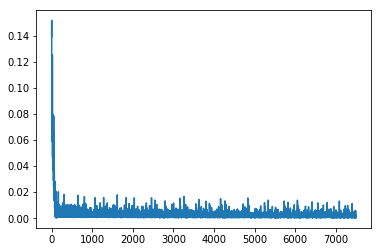

In [101]:
#==== Essential ========================================================#

EPOCH_NUM = 30

print('Training...\n')

init_op = tf.global_variables_initializer()
with tf.Session() as sess:

    tf.summary.FileWriter('tensorboard_examples/mlp_global', sess.graph)

    sess.run(init_op)

    loss_list = []
    for epoch in range(EPOCH_NUM):

        shuffled_x, shuffled_y = batch_shuffle(batched_x, batched_y)
        shuffled = batch_shuffle(batched_x, batched_y)

        for batch_x, batch_y in zip(shuffled_x, shuffled_y):

            loss_val, _ = sess.run(
                [loss, train_op],
                feed_dict={
                    input_x_placeholder: batch_x,
                    input_y_placeholder: batch_y,
                },
            )
            loss_list += [loss_val]

        print_num = EPOCH_NUM / 10
        if epoch % print_num == 0:
            print(f'Epoch: {epoch + 1}  loss={loss_val:.7f}')

    print('\nTraining Finished.')
    
    evaluate_val = sess.run(
        loss,
        feed_dict={
            input_x_placeholder: test_x_mlp,
            input_y_placeholder: test_y_mlp,
        },
    )
    predictions = sess.run(
        logits,
        feed_dict={
            input_x_placeholder: test_x_mlp,
        },
    )

#=======================================================================#

print(f'\n{"=" * 26}\n| Evaluation : {np.mean(evaluate_val):.7f} |\n{"=" * 26}')
plt.plot(loss_list, label=['loss'])

## MLP with `tf.variable_scope`

In [102]:
input_dim  = train_x_mlp.shape[1]  # 3
output_dim = train_y_mlp.shape[1]  # 2

unit_num_1 = 4
unit_num_2 = 2

In [103]:
tf.reset_default_graph()


with tf.variable_scope('Model', reuse=tf.AUTO_REUSE):


    with tf.name_scope('Input_Layer'):
        input_x_placeholder = tf.placeholder(tf.float32, shape=(None, input_dim), name='X')
        input_y_placeholder = tf.placeholder(tf.float32, shape=(None, output_dim), name='Y')


    with tf.variable_scope('Dense_Layer_1', reuse=tf.AUTO_REUSE):
        weight_1 = tf.get_variable(
            'w1',
            shape=(input_dim, unit_num_1),
            dtype=tf.float32,
            initializer=tf.random_normal_initializer(),
        )
        biases_1 = tf.get_variable(
            'b1',
            shape=(unit_num_1, ),
            dtype=tf.float32,
            initializer=tf.random_normal_initializer(),
        )
        layer_1 = (input_x_placeholder @ weight_1) + biases_1
        activation_1 = tf.sigmoid(layer_1)


    with tf.variable_scope('Dense_Layer_2', reuse=tf.AUTO_REUSE):
        weight_2 = tf.get_variable(
            'w2',
            shape=(unit_num_1, unit_num_2),
            dtype=tf.float32,
            initializer=tf.random_normal_initializer(),
        )
        biases_2 = tf.get_variable(
            'b2',
            shape=(unit_num_2, ),
            dtype=tf.float32,
            initializer=tf.random_normal_initializer(),
        )
        layer_2 = (activation_1 @ weight_2) + biases_2
        activation_2 = tf.sigmoid(layer_2)
    

    logits = activation_2


with tf.variable_scope('Optimization'):
    loss = tf.losses.mean_squared_error(
        labels=input_y_placeholder,
        predictions=logits,
    )
    train_op = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)

Training...

Epoch: 1  loss=0.0019961
Epoch: 4  loss=0.0011309
Epoch: 7  loss=0.0018993
Epoch: 10  loss=0.0012472
Epoch: 13  loss=0.0012941
Epoch: 16  loss=0.0005928
Epoch: 19  loss=0.0043274
Epoch: 22  loss=0.0076786
Epoch: 25  loss=0.0006071
Epoch: 28  loss=0.0006880

Training Finished.

| Evaluation : 0.0033011 |


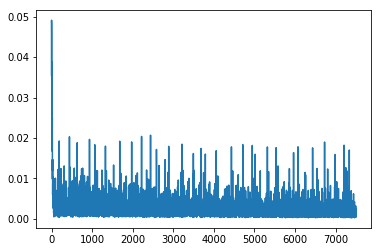

In [104]:
#==== Essential ========================================================#

EPOCH_NUM = 30

print('Training...\n')

init_op = tf.global_variables_initializer()
with tf.Session() as sess:

    tf.summary.FileWriter('tensorboard_examples/mlp_scope', sess.graph)

    sess.run(init_op)

    loss_list = []
    for epoch in range(EPOCH_NUM):

        shuffled_x, shuffled_y = batch_shuffle(batched_x, batched_y)
        shuffled = batch_shuffle(batched_x, batched_y)

        for batch_x, batch_y in zip(shuffled_x, shuffled_y):

            loss_val, _ = sess.run(
                [loss, train_op],
                feed_dict={
                    input_x_placeholder: batch_x,
                    input_y_placeholder: batch_y,
                },
            )
            loss_list += [loss_val]

        print_num = EPOCH_NUM / 10
        if epoch % print_num == 0:
            print(f'Epoch: {epoch + 1}  loss={loss_val:.7f}')

    print('\nTraining Finished.')
    
    evaluate_val = sess.run(
        loss,
        feed_dict={
            input_x_placeholder: test_x_mlp,
            input_y_placeholder: test_y_mlp,
        },
    )
    predictions = sess.run(
        logits,
        feed_dict={
            input_x_placeholder: test_x_mlp,
        },
    )

#=======================================================================#

print(f'\n{"=" * 26}\n| Evaluation : {np.mean(evaluate_val):.7f} |\n{"=" * 26}')
plt.plot(loss_list, label=['loss'])

## MLP with `tf.layers`

<br>
<img src='images/mlp_tf/tensorflow_programming_environment.png' width='80%'>
<br>

In [49]:
def dense_layer(
    input_x,
    output_dim,
    activation=tf.nn.sigmoid,
    is_training=True,
    reuse=tf.AUTO_REUSE,
    name='dense',
    ):
    
    with tf.variable_scope(name, reuse=reuse):
        densed = tf.layers.dense(
            input_x,
            units=output_dim,
            activation=activation,
            kernel_initializer=tf.random_normal_initializer(),
            name=name,
        )

    print(name, densed.get_shape())

    return densed

In [105]:
tf.reset_default_graph()


with tf.variable_scope('Model', reuse=tf.AUTO_REUSE):


    with tf.name_scope('Input_Layer'):
        input_x_placeholder = tf.placeholder(tf.float32, shape=(None, input_dim), name='X')
        input_y_placeholder = tf.placeholder(tf.float32, shape=(None, output_dim), name='Y')


    #==== Essential ========================================================#

    dense_1 = dense_layer(
        input_x_placeholder,
        output_dim=unit_num_1,
        activation=tf.nn.sigmoid,
        name='Dense_Layer_1',
    )
    dense_2 = dense_layer(
        dense_1,
        output_dim=unit_num_2,
        activation=tf.nn.sigmoid,
        name='Dense_Layer_2',
    )    
    logits = dense_2
    
    #=======================================================================#


with tf.variable_scope('Optimization'):
    loss = tf.losses.mean_squared_error(
        labels=input_y_placeholder,
        predictions=logits,
    )
    train_op = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)

Dense_Layer_1 (?, 4)
Dense_Layer_2 (?, 2)


Training...

Epoch: 1  loss=0.0009679
Epoch: 4  loss=0.0084020
Epoch: 7  loss=0.0029842
Epoch: 10  loss=0.0011518
Epoch: 13  loss=0.0026667
Epoch: 16  loss=0.0024033
Epoch: 19  loss=0.0023306
Epoch: 22  loss=0.0019045
Epoch: 25  loss=0.0012633
Epoch: 28  loss=0.0008637

Training Finished.

| Evaluation : 0.0033331 |


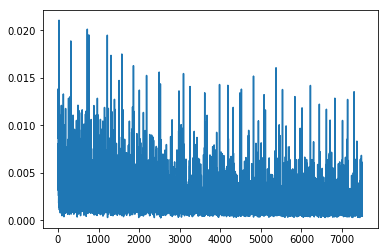

In [106]:
#==== Essential ========================================================#

EPOCH_NUM = 30

print('Training...\n')

init_op = tf.global_variables_initializer()
with tf.Session() as sess:

    tf.summary.FileWriter('tensorboard_examples/mlp_layers', sess.graph)

    sess.run(init_op)

    loss_list = []
    for epoch in range(EPOCH_NUM):

        shuffled_x, shuffled_y = batch_shuffle(batched_x, batched_y)
        shuffled = batch_shuffle(batched_x, batched_y)

        for batch_x, batch_y in zip(shuffled_x, shuffled_y):

            loss_val, _ = sess.run(
                [loss, train_op],
                feed_dict={
                    input_x_placeholder: batch_x,
                    input_y_placeholder: batch_y,
                },
            )
            loss_list += [loss_val]

        print_num = EPOCH_NUM / 10
        if epoch % print_num == 0:
            print(f'Epoch: {epoch + 1}  loss={loss_val:.7f}')

    print('\nTraining Finished.')
    
    evaluate_val = sess.run(
        loss,
        feed_dict={
            input_x_placeholder: test_x_mlp,
            input_y_placeholder: test_y_mlp,
        },
    )
    predictions = sess.run(
        logits,
        feed_dict={
            input_x_placeholder: test_x_mlp,
        },
    )

#=======================================================================#

print(f'\n{"=" * 26}\n| Evaluation : {np.mean(evaluate_val):.7f} |\n{"=" * 26}')
plt.plot(loss_list, label=['loss'])

End of Document.